In [1]:
import BLSTM_ATT
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Get data, 数据增强，在5-1中筛选了数据进行补充，其余作为测试数据
# 根据进水COD总氮划分数据集，选代表性的数据

In [2]:
# 获取数据，看COD和总氮的范围
data = np.load('./databygroup.npy',allow_pickle=True).tolist()

TrainData,TestData={},{}
for k in data.keys():
    TrainData[k]=data[k]
    TestData[k]=data[k]
        
#Tdata=TrainData[TrainData.keys()]
step=20
xtrain,ytrain=[],[]
for k in TrainData.keys():
    for i in range(int(0.8*TrainData[k].shape[0])-step-1):
        xtrain.append(TrainData[k][i:i+step,:TrainData[k].shape[1]-5].tolist())
        ytrain.append(TrainData[k][i+1+step,[-5,-4,-3,-2,-1]].tolist())

xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

In [3]:
# data前4个feature分别为in NH4、TN、flow、COD、T，由此选TN and COD分类
# 找最大最小值

# 各分5份，构造选数据条件
n = 5
TNrange = np.linspace(np.max(xtrain[:,:,1]),np.min(xtrain[:,:,1]),n+1)
CODrange = np.linspace(np.max(xtrain[:,:,3]),np.min(xtrain[:,:,3]),n+1)
print(TNrange,CODrange)

# 根据上述条件分数据，一共有25组数据
# 因为数据为20个时间步一条，所以用20个时间步的平均值作为分类条件

group_datax, group_datay = {}, {}

for TNid in range(len(TNrange)-1):
    for CODid in range(len(CODrange)-1):
        group_datax['TN'+str(TNid)+'_COD'+str(CODid)] = []
        group_datay['TN'+str(TNid)+'_COD'+str(CODid)] = []


for i in range(xtrain.shape[0]):

    meanTN, meanCOD = np.mean(xtrain[i,:,1]), np.mean(xtrain[i,:,3])
    logTN, logCOD = 0, 0

    # TN
    if meanTN == TNrange[0]:
        logTN = 0
    else:
        for k in range(len(TNrange)-1):
            if meanTN < TNrange[k] and meanTN >= TNrange[k+1]:
                logTN = k
    
    # COD
    if meanCOD == CODrange[0]:
        logCOD = 0
    else:
        for k in range(len(CODrange)-1):
            if meanCOD < CODrange[k] and meanCOD >= CODrange[k+1]:
                logCOD = k

    group_datax['TN'+str(logTN)+'_COD'+str(logCOD)].append(xtrain[i,:,:].tolist())
    group_datay['TN'+str(logTN)+'_COD'+str(logCOD)].append(ytrain[i,:].tolist())
    
# 删除没有数据的分组
logk = []
for k in group_datay.keys():
    if len(group_datay[k]) == 0:
        logk.append(k)

for k in logk:
    group_datax.pop(k)
    group_datay.pop(k)

[ 0.98123475  0.58881659  0.19639842 -0.19601974 -0.58843791 -0.98085607] [ 1.          0.60231696  0.20463393 -0.19304911 -0.59073214 -0.98841518]


In [4]:
# 从上述每个分组中选出代表性数据
# 在保证选出数据总数与Koopman方法一致的前提下，按照各个分类的比例选数据

# K方法选出的数据总共有 23032 条

# 确定每个分类的比例
num = {}
sumk = 0
for k in group_datay.keys():
    num[k] = len(group_datay[k])
    sumk += len(group_datay[k])

for k in group_datay.keys():
    num[k] = int(23032*num[k]/sumk)

xtrain, ytrain = [], []
for k in group_datax.keys():

    for i in range(num[k]):
        xtrain.append(group_datax[k][i])
        ytrain.append(group_datay[k][i])

xtrain = Variable(torch.FloatTensor(xtrain))
ytrain = Variable(torch.FloatTensor(ytrain))
print(xtrain.shape,ytrain.shape)


torch.Size([23024, 20, 15]) torch.Size([23024, 5])


In [7]:
ind = np.array([i for i in range(int(xtrain.shape[0]*0.7))])
print(ind.shape)
np.save('./0.7alldata_v2.npy',ind)

(16116,)


# Attention

## 训练

In [5]:
param={
    'embedding_dim':xtrain.shape[2], 
    'num_hiddens':100, 
    'windowsize':xtrain.shape[1],
    'num_layers':4,
    'output_dim':ytrain.shape[1], 
    'learning_rate':0.0001,
    'opt':'Adam',
    }

In [8]:
net = BLSTM_ATT.Net(param)
print(net)

ind = np.load('./0.7alldata_v2.npy').tolist()
mask = np.ones(xtrain.shape[0], dtype=bool)
mask[ind] = False

optimizer = torch.optim.Adam(net.parameters(),lr = param['learning_rate'])
loss_func = torch.nn.MSELoss()
mse,vmse=[],[]
xt, yt = xtrain[ind], ytrain[ind]
xv, yv = xtrain[mask], ytrain[mask]

for t in range(1000):
    output = net(xtrain)
    loss = loss_func(output,ytrain)

    vp = net(xv)
    lossv = loss_func(vp,yv)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    mse.append(loss.detach().numpy())
    vmse.append(lossv.detach().numpy())
    print('Epoch:', t, ' Loss:',mse[-1],' vLoss:',vmse[-1])
    
    if np.mod(t,10)==0:
        np.save('./ATT_mse.npy',mse)
        np.save('./ATT_vmse.npy',vmse)

Net(
  (encoder): LSTM(15, 100, num_layers=4, batch_first=True, bidirectional=True)
  (decoder): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 0  Loss: 0.20124808  vLoss: 0.28610396
Epoch: 1  Loss: 0.19888885  vLoss: 0.28338343
Epoch: 2  Loss: 0.19655587  vLoss: 0.28068665
Epoch: 3  Loss: 0.19424663  vLoss: 0.2780108
Epoch: 4  Loss: 0.19195822  vLoss: 0.27535257
Epoch: 5  Loss: 0.18968768  vLoss: 0.2727087
Epoch: 6  Loss: 0.18743204  vLoss: 0.27007607
Epoch: 7  Loss: 0.18518825  vLoss: 0.26745132
Epoch: 8  Loss: 0.18295327  vLoss: 0.26483086
Epoch: 9  Loss: 0.18072398  vLoss: 0.26221108
Epoch: 10  Loss: 0.17849717  vLoss: 0.25958812
Epoch: 11  Loss: 0.17626958  vLoss: 0.25695816
Epoch: 12  Loss: 0.17403796  vLoss: 0.25431713
Epoch: 13  Loss: 0.17179906  vLoss: 0.25166097
Epoch: 14  Loss: 0.16954964  vLoss: 0.24898553
Epoch: 15  Loss: 0.16728649  vLoss: 0.24628651
Epoch: 16  Loss: 0.16500649  vLoss: 0.24355963
Epoch: 17  Loss: 0.16270654  vLoss: 0.24080051
Epoch: 18  Loss:

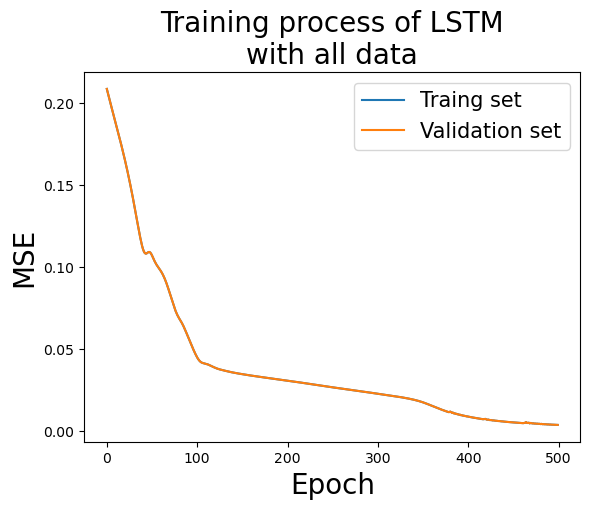

In [ ]:
#font1={'family':'Times New Roman','weight':'normal','size':20}
#font2={'family':'Times New Roman','weight':'normal','size':10}
font1={'weight':'normal','size':20}
font2={'weight':'normal','size':10}

plt.plot(mse,label='Traing set')
plt.plot(vmse,label='Validation set')
plt.title('Training process of LSTM'+'\n'+'with all data',font=font1)
plt.xlabel('Epoch',font=font1)
plt.ylabel('MSE',font=font1)
plt.legend(prop = {'size':15})